# 行列の計算量に関するメモ

- 行列の和
- 行列の積

についての計算量を考えてみる．

ここでは，行列の計算量を考えるために，あえて Python の `list` を使って実現します．
普通は，この手の計算は `numpy` を使います．

## 行列の和に関して

行列を表現するには，`list` を入れ子構造にして（いわゆる `list` の `list`）を用いて行列を表現します．
純粋に行列の足し算 `add_mat` と掛け算 `mul_mat` の性能をみるために，初期化した配列 `C` を渡して，
`A`, `B` の演算を計算していきます．

In [6]:
# 原始的な行列の和
def add_mat(C, A, B):
    for i in range(len(C)):
        for j in range(len(C[i])):
            C[i][j] = A[i][j] + B[i][j]
    return C


# 原始的な行列の積
def mul_mat(C, A, B):
    for i in range(len(C)):
        for j in range(len(C[i])):
            C[i][j] = 0
            for k in range(len(A[i])):
                C[i][j] += A[i][k] * B[k][j]
    return C


# 初期化用
def zero_mat(nrows, ncols):
    '''0で初期化する'''
    C = []
    for i in range(nrows):
        row = []
        for j in range(ncols):
            row.append(0)
        C.append(row)
    return C


# 乱数で初期化するのも作っておく
import random

def rand_mat(nrows, ncols):
    '''乱数で初期化する'''
    C = []
    for i in range(nrows):
        row = []
        for j in range(ncols):
            row.append(random.randint(0, 9))
        C.append(row)
    return C

おおよそ，Python らしからぬコードが出来上がりました．

が，めげすにテストします

In [4]:
A = [[1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]]

B = [[1, 4, 7],
    [2, 5, 8],
    [3, 6, 9]
    ]

C = zero_mat(3, 3)
add_mat(C, A, B)
print(C)

D = zero_mat(3, 3)
mul_mat(D, A, B)
print(D)

# 結果が正しいか numpy に喰わせて合っているかを確認
import numpy as np
print(np.array(A) + np.array(B))
print(np.array(A) @ np.array(B))

[[2, 6, 10], [6, 10, 14], [10, 14, 18]]
[[14, 32, 50], [32, 77, 122], [50, 122, 194]]
[[ 2  6 10]
 [ 6 10 14]
 [10 14 18]]
[[ 14  32  50]
 [ 32  77 122]
 [ 50 122 194]]


## 時間を計測してみる

どうやら正しそうなので，行列のスケールで演算スピードがどのくらい変わるかを実験します．

In [9]:
# とりあえず size = 10 くらいで計測してみる

size = 10

A = rand_mat(size, size)
B = rand_mat(size, size)
C = zero_mat(size, size)

import timeit
add_time = timeit.timeit(lambda: add_mat(C, A, B), number=100)
mul_time = timeit.timeit(lambda: mul_mat(C, A, B), number=100)

print(f"add_mat() time:{add_time:08f} [sec]")
print(f"mul_mat() time:{mul_time:08f} [sec]")

add_mat() time:0.001942
mul_mat() time:0.021729


In [24]:
# じゃ，あとは pandas に入れて，プロットするだけ

import pandas as pd

data_list = []

for size in range(1, 50):
    A = rand_mat(size, size)
    B = rand_mat(size, size)
    C = zero_mat(size, size)

    add_time = timeit.timeit(lambda: add_mat(C, A, B), number=100)
    mul_time = timeit.timeit(lambda: mul_mat(C, A, B), number=100)

    data_list.append([size, add_time, mul_time])

df = pd.DataFrame(data_list, columns=["size", "add_time", "mul_time"])

df.head()

# m1 macbook pro で15秒くらいかかる

,size,add_time,mul_time
0,1,0.000094,0.000118
1,2,0.000147,0.000362
2,3,0.000248,0.001527
3,4,0.000374,0.001880
4,5,0.000521,0.003241


<Axes: xlabel='size'>

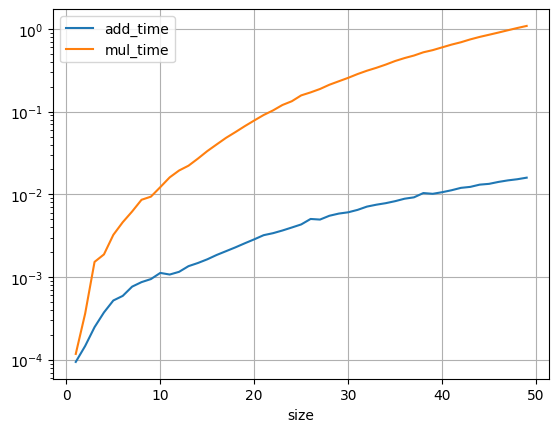

In [25]:
# グラフを描画してみよう
df.plot(x="size", y=["add_time", "mul_time"], logy=True, grid=True)

## おまけ

ちなみにふつーの numpy を使った例で測ってみるとどうなるか．


In [26]:
import numpy as np

data_list_np = []

def add_mat_np(C, A, B):
    C = np.array(A) + np.array(B)

def mul_mat_np(C, A, B):
    C = np.array(A) @ np.array(B)

for size in range(1, 50):
    A = rand_mat(size, size)
    B = rand_mat(size, size)
    C = zero_mat(size, size)

    add_time = timeit.timeit(lambda: add_mat_np(C, A, B), number=100)
    mul_time = timeit.timeit(lambda: mul_mat_np(C, A, B), number=100)

    data_list_np.append([size, add_time, mul_time])
    
df_np = pd.DataFrame(data_list_np, columns=["size", "add_time", "mul_time"])
df_np.head()

# こっちは 0.6秒くらいで終わる

,size,add_time,mul_time
0,1,0.000254,0.000291
1,2,0.000281,0.000352
2,3,0.000375,0.000452
3,4,0.000493,0.000570
4,5,0.000631,0.001040


<Axes: xlabel='size'>

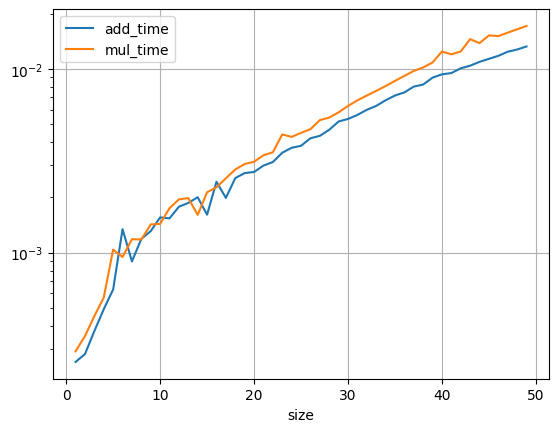

In [27]:
# グラフを描画してみよう
df_np.plot(x="size", y=["add_time", "mul_time"], logy=True, grid=True)

変換時間含めても，`size = 50` で，おおよそ，掛け算は100倍くらい違う．

## 結論
- 行列計算の様に内部ループの多さによって計算オーダーは劇的に変化する